In [48]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from tqdm import tqdm
import timm
import h5py
import numpy as np
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from scipy.stats import pearsonr, pointbiserialr

In [6]:
train_csv = pd.read_csv("train-metadata.csv")

/var/folders/tk/gjqscy953w90qhs86864yqf00000gn/T/ipykernel_12880/1863284004.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_csv = pd.read_csv("train-metadata.csv")


In [7]:
train_csv.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [8]:
train_csv.isna().sum()

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

In [9]:
train_csv.describe()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,...,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,...,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,...,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,...,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,...,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,...,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,...,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,...,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


In [10]:
train_csv.shape

(401059, 55)

In [11]:
train_csv.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [12]:
test_csv = pd.read_csv("test-metadata.csv")

In [13]:
test_csv.shape

(3, 44)

In [14]:
test_csv.columns

Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')

In [15]:
test_csv.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,31.114600,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,68.141071,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,41.358640,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [17]:
train_csv['patient_id'].nunique()

1042

In [18]:
train_csv.shape[0]/train_csv['patient_id'].nunique()

384.8934740882917

In [19]:
# Find the number of unique male and female patients
unique_male_patients = train_csv[train_csv['sex'] == 'male']['patient_id'].nunique()
unique_female_patients = train_csv[train_csv['sex'] == 'female']['patient_id'].nunique()
print(f"the number of male patients is {unique_male_patients} and the number of female patients is {unique_female_patients}")

the number of male patients is 551 and the number of female patients is 458


In [56]:
cancer_positive = train_csv[train_csv['target']==1]

# Find the number of unique male and female patients
unique_male_patients = cancer_positive[cancer_positive['sex'] == 'male']['patient_id'].nunique()
unique_female_patients = cancer_positive[cancer_positive['sex'] == 'female']['patient_id'].nunique()
print(f"the number of cancerous male patients is {unique_male_patients} and the number of  cancerous female patients is {unique_female_patients}")



the number of cancerous male patients is 159 and the number of  cancerous female patients is 92


In [57]:
cancer_positive.shape

(393, 55)

In [59]:
cancer_positive['patient_id'].nunique()

259

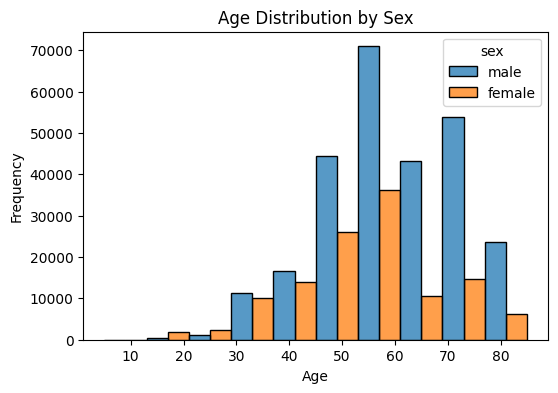

In [24]:
# Plot age distribution
plt.figure(figsize=(6, 4))
sns.histplot(data=train_csv, x='age_approx', hue='sex', multiple='dodge', bins=10)
plt.title('Age Distribution by Sex')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [25]:
test_csv.isna().sum()

isic_id                        0
patient_id                     0
age_approx                     0
sex                            0
anatom_site_general            0
clin_size_long_diam_mm         0
image_type                     0
tbp_tile_type                  0
tbp_lv_A                       0
tbp_lv_Aext                    0
tbp_lv_B                       0
tbp_lv_Bext                    0
tbp_lv_C                       0
tbp_lv_Cext                    0
tbp_lv_H                       0
tbp_lv_Hext                    0
tbp_lv_L                       0
tbp_lv_Lext                    0
tbp_lv_areaMM2                 0
tbp_lv_area_perim_ratio        0
tbp_lv_color_std_mean          0
tbp_lv_deltaA                  0
tbp_lv_deltaB                  0
tbp_lv_deltaL                  0
tbp_lv_deltaLB                 0
tbp_lv_deltaLBnorm             0
tbp_lv_eccentricity            0
tbp_lv_location                0
tbp_lv_location_simple         0
tbp_lv_minorAxisMM             0
tbp_lv_nev

In [28]:
# Find columns in df1 that are not in df2
columns_not_in_test = train_csv.columns.difference(test_csv.columns)

print("Columns in train not in test:", columns_not_in_test)

Columns in train not in test: Index(['iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'iddx_full',
       'lesion_id', 'mel_mitotic_index', 'mel_thick_mm', 'target',
       'tbp_lv_dnn_lesion_confidence'],
      dtype='object')


In [29]:
# Drop these columns from df1
train_dropped = train_csv.drop(columns=columns_not_in_test)


In [30]:
train_dropped.isna().sum()

isic_id                            0
patient_id                         0
age_approx                      2798
sex                            11517
anatom_site_general             5756
clin_size_long_diam_mm             0
image_type                         0
tbp_tile_type                      0
tbp_lv_A                           0
tbp_lv_Aext                        0
tbp_lv_B                           0
tbp_lv_Bext                        0
tbp_lv_C                           0
tbp_lv_Cext                        0
tbp_lv_H                           0
tbp_lv_Hext                        0
tbp_lv_L                           0
tbp_lv_Lext                        0
tbp_lv_areaMM2                     0
tbp_lv_area_perim_ratio            0
tbp_lv_color_std_mean              0
tbp_lv_deltaA                      0
tbp_lv_deltaB                      0
tbp_lv_deltaL                      0
tbp_lv_deltaLB                     0
tbp_lv_deltaLBnorm                 0
tbp_lv_eccentricity                0
t

In [35]:
test_csv.columns

Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')

In [36]:
# Note: This is more meaningful for numerical data
selected_columns = train_csv.select_dtypes(include=['number']).columns
selected_columns


Index(['target', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence'],
      dtype='object')

In [40]:
columns_to_remove = ['mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence']

selected_columns = selected_columns.drop(columns_to_remove)

In [42]:
train_csv[selected_columns].columns

Index(['target', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'],
      dtype='object')

In [43]:
train_csv[selected_columns].isna().sum()

target                            0
age_approx                     2798
clin_size_long_diam_mm            0
tbp_lv_A                          0
tbp_lv_Aext                       0
tbp_lv_B                          0
tbp_lv_Bext                       0
tbp_lv_C                          0
tbp_lv_Cext                       0
tbp_lv_H                          0
tbp_lv_Hext                       0
tbp_lv_L                          0
tbp_lv_Lext                       0
tbp_lv_areaMM2                    0
tbp_lv_area_perim_ratio           0
tbp_lv_color_std_mean             0
tbp_lv_deltaA                     0
tbp_lv_deltaB                     0
tbp_lv_deltaL                     0
tbp_lv_deltaLB                    0
tbp_lv_deltaLBnorm                0
tbp_lv_eccentricity               0
tbp_lv_minorAxisMM                0
tbp_lv_nevi_confidence            0
tbp_lv_norm_border                0
tbp_lv_norm_color                 0
tbp_lv_perimeterMM                0
tbp_lv_radial_color_std_max 

In [44]:
train_sub= train_csv[selected_columns]

train_sub= train_sub.dropna()




In [45]:
for col in selected_columns:
    if col != 'target':
        correlation, _ = pearsonr(train_sub[col], train_sub['target'])
        print(f'Correlation between {col} and target: {correlation}')

Correlation between age_approx and target: 0.007734469436209222
Correlation between clin_size_long_diam_mm and target: 0.03287617454851736
Correlation between tbp_lv_A and target: 0.019868745813065972
Correlation between tbp_lv_Aext and target: 0.023163051164449864
Correlation between tbp_lv_B and target: -0.02641747398271307
Correlation between tbp_lv_Bext and target: -0.013842999350616251
Correlation between tbp_lv_C and target: -0.009415085391447028
Correlation between tbp_lv_Cext and target: -0.0009103395414482523
Correlation between tbp_lv_H and target: -0.04493119461625497
Correlation between tbp_lv_Hext and target: -0.03268206904733742
Correlation between tbp_lv_L and target: -0.003895214098295603
Correlation between tbp_lv_Lext and target: -0.00029773881023397266
Correlation between tbp_lv_areaMM2 and target: 0.04534817985191942
Correlation between tbp_lv_area_perim_ratio and target: 0.009852028456729915
Correlation between tbp_lv_color_std_mean and target: 0.02423214180674977


target                         1.000000
tbp_lv_areaMM2                 0.045348
tbp_lv_perimeterMM             0.036430
tbp_lv_minorAxisMM             0.035983
clin_size_long_diam_mm         0.032876
tbp_lv_stdLExt                 0.026356
tbp_lv_radial_color_std_max    0.025487
tbp_lv_color_std_mean          0.024232
tbp_lv_Aext                    0.023163
tbp_lv_norm_color              0.022343
tbp_lv_A                       0.019869
tbp_lv_deltaLBnorm             0.014998
tbp_lv_stdL                    0.012492
tbp_lv_deltaLB                 0.012154
tbp_lv_area_perim_ratio        0.009852
tbp_lv_y                       0.009783
age_approx                     0.007734
tbp_lv_norm_border             0.006946
tbp_lv_symm_2axis              0.002712
tbp_lv_symm_2axis_angle        0.000862
tbp_lv_Lext                   -0.000298
tbp_lv_deltaA                 -0.000893
tbp_lv_Cext                   -0.000910
tbp_lv_x                      -0.002542
tbp_lv_L                      -0.003895


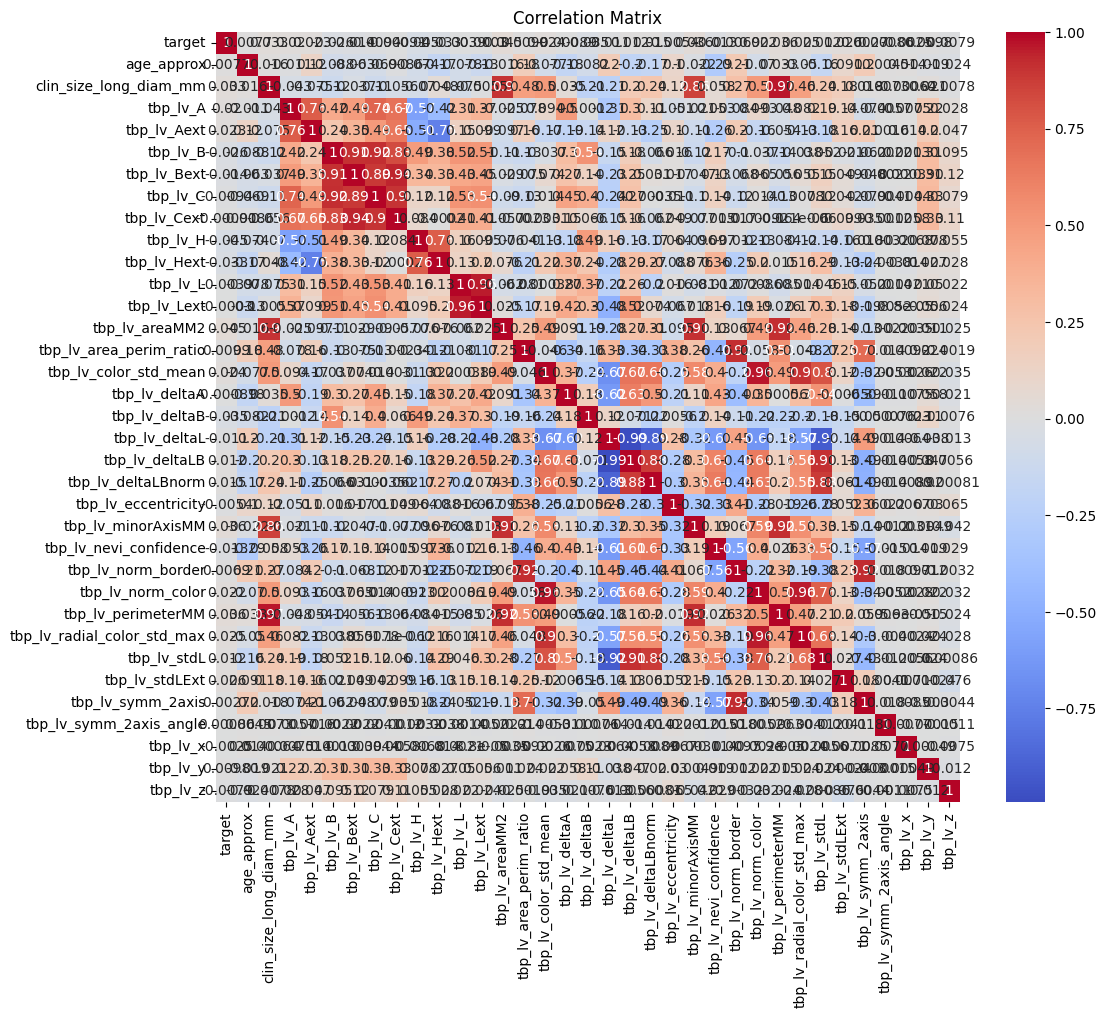

In [46]:
# Check the correlation between numeric features and the target
correlation = train_sub.corr()
print(correlation['target'].sort_values(ascending=False))

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [50]:

# Select numeric features
numeric_columns = train_sub.select_dtypes(include=['number']).columns


# Calculate Point-Biserial correlation
pointbiserial_correlations = {}
for col in numeric_columns:
    if col != 'target':
        correlation, _ = pointbiserialr(train_sub[col], train_sub['target'])
        pointbiserial_correlations[col] = correlation


pointbiserial_df = pd.DataFrame(pointbiserial_correlations.items(), columns=['Feature', 'Point-Biserial Correlation'])
pointbiserial_df = pointbiserial_df.sort_values(by='Point-Biserial Correlation', ascending=False)

print("\nPoint-Biserial Correlation:")
print(pointbiserial_df)


Point-Biserial Correlation:
                        Feature  Point-Biserial Correlation
12               tbp_lv_areaMM2                    0.045348
25           tbp_lv_perimeterMM                    0.036430
21           tbp_lv_minorAxisMM                    0.035983
1        clin_size_long_diam_mm                    0.032876
28               tbp_lv_stdLExt                    0.026356
26  tbp_lv_radial_color_std_max                    0.025487
14        tbp_lv_color_std_mean                    0.024232
3                   tbp_lv_Aext                    0.023163
24            tbp_lv_norm_color                    0.022343
2                      tbp_lv_A                    0.019869
19           tbp_lv_deltaLBnorm                    0.014998
27                  tbp_lv_stdL                    0.012492
18               tbp_lv_deltaLB                    0.012154
13      tbp_lv_area_perim_ratio                    0.009852
32                     tbp_lv_y                    0.009783
0          

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

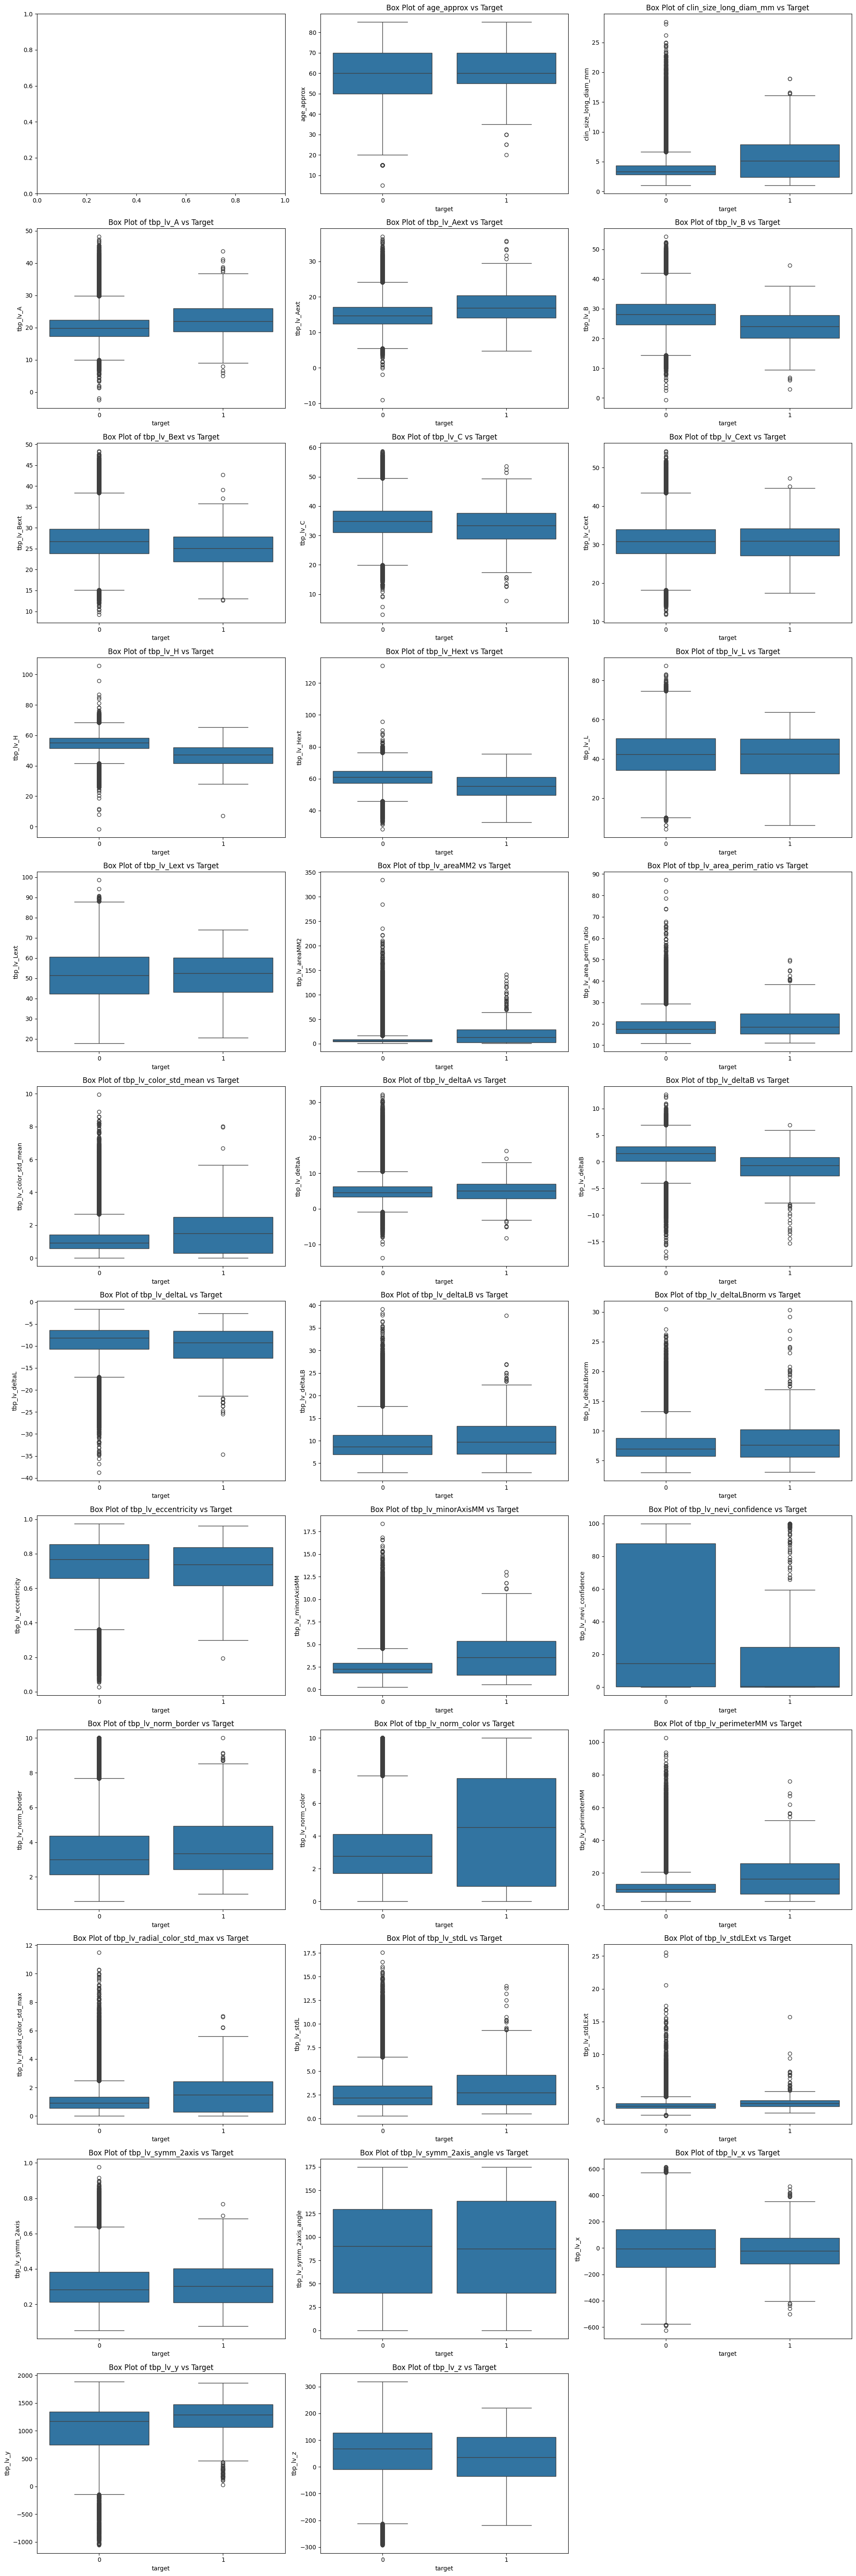

In [55]:
# Select numeric features
numeric_columns = train_sub.select_dtypes(include=['number']).columns


# Number of numeric columns
num_plots = len(numeric_columns) - 1  # excluding the 'target' column

# Define the number of rows and columns for the subplots grid
n_cols = 3  # number of columns in the grid
n_rows = (num_plots + n_cols - 1) // n_cols  # number of rows in the grid

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each numeric column against the target
for i, col in enumerate(numeric_columns):
    if col != 'target':
        sns.boxplot(x='target', y=col, data=train_sub, ax=axes[i])
        axes[i].set_title(f'Box Plot of {col} vs Target')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()